In [1]:
import pandas as pd
import numpy as np
from sqlalchemy import engine
import folium
import geopandas as gpd
from shapely.geometry import Point


In [2]:
conn_string = r"postgresql://masterschool-analyst:pa84cc0d01e9b241460abdf838bb34f5932c9473dca571b56fcb13dd3023a62e0@ec2-52-4-84-108.compute-1.amazonaws.com:5432/da541q56oobji4"
connection = engine.create_engine(conn_string)

In [3]:
cte_query = """
  SELECT 
    order_id, 
    partner_id AS operator_id, 
    partner_name AS operator_name, 
    status, 
    m.source, 
    fullname, 
    email AS customer_email, 
    company_name, 
    confirmation_id, 
    space_id, 
    space_name, 
    created_at, 
    promotion_code, 
    total_price AS final_price, 
    --not usd,  sub_total + tax_amount, sub_total=order_line_item_total_price
    ABS(discounted_amount) AS discounted_amount, 
    --not usd
    total_price_in_usd AS final_price_usd, 
    --amount transacted through Flexspace
    ABS(ROUND(
      discounted_amount * to_usd_rate, 2
    )) AS discounted_amount_usd, 
    ROUND(
      (
        total_price_in_usd + ABS(discounted_amount * to_usd_rate)
      ), 
      2
    ) AS original_price_usd, 
    processing_fee_in_usd, 
    to_usd_rate, 
    location_id, 
    location_name_en, 
    location_time_zone, 
    country, 
    m.state, 
    city, 
    order_line_item_id, 
    orderable_type, 
    orderable_id, 
    order_line_item_details, 
    access_id, 
    booking_product_type, 
    product_type_id, 
    add_on_days_to_expire, 
    capacity, 
    booking_id, 
    start_date, 
    end_date, 
    date, 
    quantity, 
    last_refresh 
  FROM 
    mat_orders AS m 
  WHERE 
    status = 'paid' 
    AND email NOT IN (
      SELECT 
        email 
      FROM 
        mat_orders 
      WHERE 
        1 = 1 
        AND (
          company_name ILIKE '%%test%%'
          OR fullname ILIKE '%%test%%' 
          OR email ILIKE '%%test%%' 
          OR promotion_code ILIKE '%%test%%'
          OR partner_name ILIKE '%%test%%'
        )
    ) 
    AND m.source IN ('WL', 'FM')
    AND created_at < '2023-07-01'
;

"""

filtered_df = pd.read_sql(cte_query, con=conn_string)

## Geographical spread

In [4]:
lonlat_query = """select partner_name || ' - ' || space_name as space_name
    , coalesce(mat_orders.city, locations.city) as city
    , coalesce(mat_orders.country, locations.country) as country
    , coalesce(mat_orders.state, locations.state) as state
    , longitude
    , latitude
    , count(order_id)
from mat_orders
left join locations
    on mat_orders.location_id = locations.id
where 1=1
and source in ('WL', 'FM')
AND status ='paid'
AND mat_orders.created_at < '2023-07-01'
 AND email NOT IN (
      SELECT
        email
      FROM
        mat_orders
      WHERE
        1 = 1
        AND (
          company_name ILIKE '%%test%%'
          OR fullname ILIKE '%%test%%'
          OR email ILIKE '%%test%%'
          OR promotion_code ILIKE '%%test%%'
          OR partner_name ILIKE '%%test%%'
        )
    )
group by 1,2,3,4,5,6;

"""

locations_ = pd.read_sql(lonlat_query, con=conn_string)

In [5]:
locations_ = locations_.dropna(thresh=5).copy()
gdf_ = gpd.GeoDataFrame(locations_, geometry=gpd.points_from_xy(locations_['longitude'], locations_['latitude']))


## Create Interactive maps 

In [6]:
def create_maps(gdf, is_global=True):
    
    def map_creator(temp_df, city):    
        # Add points to the map
        for idx, row in temp.iterrows():
            popup_text = str(row['count'])

            folium.CircleMarker(location=(row['latitude'], row['longitude']),
                                radius=row['count']/10, # change this value to adjust the size of the circle markers
                                color="blue", 
                                popup=folium.Popup(popup_text), 
                                fill=True).add_to(m)

            m.save(f"{city.title()}.html")
        
    if is_global:
        temp = gdf[['latitude', 'longitude', 'city','count']].copy()
        temp = temp.groupby(['latitude','longitude'], as_index=False).sum().copy()
        m = folium.Map(location=[30.261042, -73.993123], zoom_start=5)
        map_creator(temp, "Global")
    else:
        for city in gdf['city'].unique():
            temp = gdf[gdf['city']==city][['latitude', 'longitude', 'city','count']].copy()
            temp = temp.groupby(['latitude','longitude'], as_index=False).sum().copy()
            m = folium.Map(location=[temp['latitude'].mean(), temp['longitude'].mean()], zoom_start=13)

            map_creator(temp, city)
            

create_maps(gdf_)
create_maps(gdf_, False)

### Get an overall sum of operators

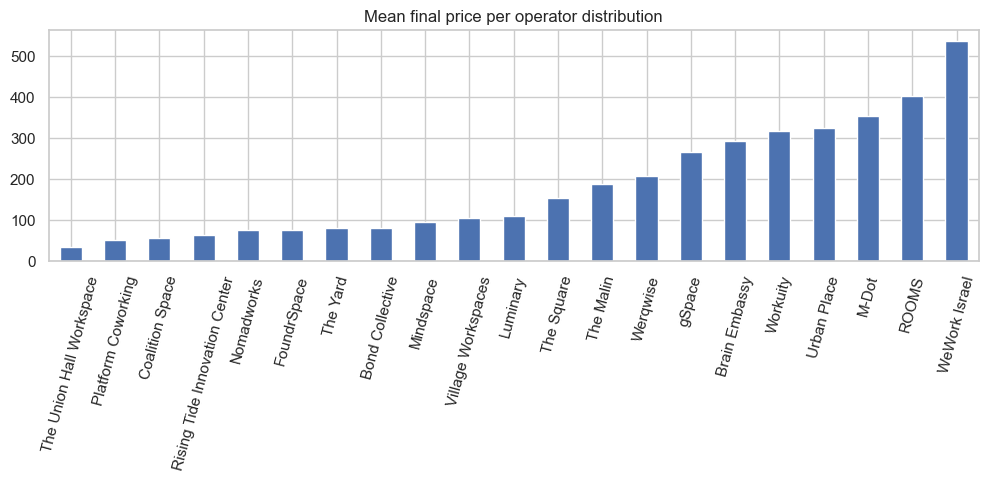

In [71]:
filtered_df.groupby('operator_name').mean()['final_price'].sort_values().plot(kind="bar", xlabel="", 
                                                                              rot=75,
                                                                              figsize=(12,3),
                                                                              title="Mean final price per operator distribution");


In [72]:
filtered_df.groupby('operator_name').sum()['final_price'].sort_values()


operator_name
The Union Hall Workspace             395.00
Coalition Space                      455.00
The Square                           760.00
Platform Coworking                   815.00
Workuity                             950.00
Rising Tide Innovation Center       1847.50
gSpace                              1850.00
Village Workspaces                  7271.60
FoundrSpace                        10972.50
Bond Collective                    30043.75
M-Dot                              35695.53
Nomadworks                         69556.50
Luminary                           84839.75
ROOMS                             105019.20
Werqwise                          115175.50
Brain Embassy                     176435.66
Urban Place                       201909.38
The Malin                         256210.25
The Yard                          269103.00
Mindspace                         862619.47
WeWork Israel                    2279715.41
Name: final_price, dtype: float64

In [74]:
# Extracting just the date from created_at as date
filtered_df['date'] = filtered_df['created_at'].dt.date

In [75]:
# Number of unique operators
filtered_df['operator_id'].nunique()

21

In [76]:
fdf = filtered_df.copy()

# Exploring features to measure success

In [77]:
import matplotlib.pyplot as plt
import seaborn as sns

In [78]:
# Convert 'date' to a time stamp
fdf['date'] = pd.to_datetime(fdf['date'])
monetary_for_preperation = fdf.groupby(['operator_id', 'customer_email','date'], as_index=False)['final_price'].sum()
interim_fdf = fdf.sort_values(['operator_id', 'customer_email','created_at']).drop_duplicates(['operator_id', 'customer_email','date'])
interim_fdf = interim_fdf.drop('final_price', axis=1)

In [79]:
fdf = interim_fdf.merge(monetary_for_preperation).copy()


In [80]:
country_totals = pd.DataFrame(fdf.groupby('country', as_index = False)['final_price_usd'].sum())

In [81]:
country_totals = country_totals.sort_values(by='final_price_usd', ascending=False).reset_index(drop=True)

In [18]:
country_totals

,country,final_price_usd
0,US,868369.54
1,IL,741107.85
2,DE,340928.25
3,GB,125481.03
4,NL,63256.89
5,PL,36958.07
6,RO,24499.01


Text(0.5, 1.0, 'Country Monetary Value')

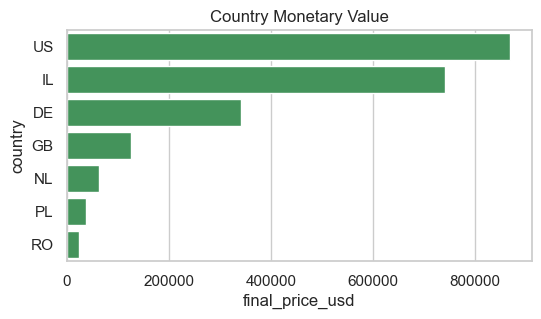

In [19]:
plt.figure(figsize = (6, 3))

sns.set(style="whitegrid", color_codes=True)

pal = sns.color_palette("Greens_d", 1)

sns.barplot(y = country_totals['country'], x = country_totals['final_price_usd'], palette= pal)

plt.title('Country Monetary Value')

The US has generated the most followed closely by Israel

In [20]:
country_operator = pd.DataFrame(fdf.groupby('country', as_index = False)['operator_name'].nunique()).sort_values(by='operator_name', ascending=False).reset_index(drop=True)
                                                                                                               

In [21]:
country_operator

,country,operator_name
0,US,16
1,IL,6
2,PL,2
3,DE,1
4,GB,1
5,NL,1
6,RO,1


Text(0.5, 1.0, 'Operators in each Country')

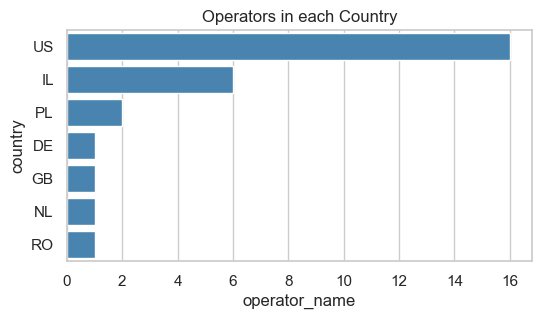

In [23]:
plt.figure(figsize = (6, 3))

sns.set(style="whitegrid", color_codes=True)

pal = sns.color_palette("Blues_d", 1)

sns.barplot(y = country_operator['country'], x = country_operator['operator_name'], palette= pal)

plt.title('Operators in each Country')

It seems a variety of operaters in a country positively correlates with higher revenues. 

Mindspace has a footprint in every country, the most being in Germany.

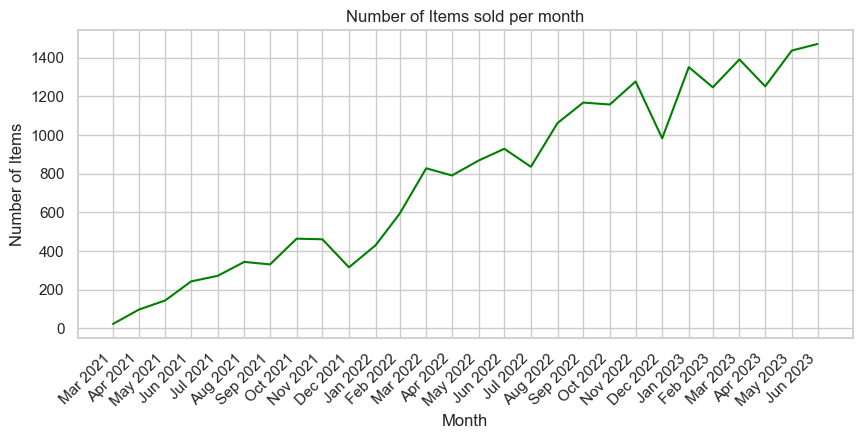

In [24]:
df_group = pd.DataFrame(fdf.resample('M', on='date')['order_id'].count())
df_group.columns = ['Number_of_items_sold']
    
plt.figure(figsize=(10, 4))
sns.lineplot(x=df_group.index, y=df_group['Number_of_items_sold'], color = 'Green')

# Set the chart title and axis labels
plt.title('Number of Items sold per month')
plt.xlabel('Month')
plt.ylabel('Number of Items')

plt.xticks(df_group.index, df_group.index.strftime('%b %Y'), rotation=45, ha='right')
plt.show()

The number of sold products has been rising steadily with the expectation of dips withiin December as seen in 2021 and 2022.

# RFM Analysis

An rfm analysis is a segmentation and behavioral targeting technique that will rank and categorize operators according to their recency, frequency, and monetary value of their transactions.

- The recency metric measures the time elapsed since an operator's transaction
- The frequency evaluates how frequently customers cunducted transactions with the operators
- The monetary values quantifies the amount of money spent

### RFM Function


In [27]:
fdf['operator_key'] = fdf['country']+"-"+np.where(fdf['state'].isin([None]),"", fdf['state']+"-")+fdf['city']
fdf['operator_full_name'] = fdf['operator_name']+"-"+fdf['country']+"-"+np.where(fdf['state'].isin([None]),"", fdf['state']+"-")+fdf['city']

pivot_table = fdf.groupby(['operator_name', 'operator_key']).size().unstack(fill_value=0)

# pivot_table.astype(bool).sum(axis=1).sort_values(ascending=False)

In [28]:
def create_extended_rfm_by(fdf_, key="operator_name"):

    # this is a bogus filter - you can change that however you like
    fdf_filtered = fdf_[fdf_['date'] < pd.to_datetime('2023-07-01')].copy()
    
    #recency and lifetime
    df_recency = fdf_filtered.groupby(key)['date'].agg(["max", "min"]).reset_index()
    df_recency.columns = ['operator', 'last_order', "first_order"]
    
    df_recency['recency'] = (pd.Timestamp.now().normalize() - df_recency['last_order']).dt.days
    df_recency['lifetime'] = (df_recency['last_order'] - df_recency['first_order']).dt.days+1
    
    #monetary and frequency 
    df_monetary_freq = fdf_filtered.groupby(key)['final_price_usd'].agg(['count', sum]).copy().reset_index()
    df_monetary_freq.columns = ['operator', 'frequency', "monetary"]

    
    # Count number of orders for each customer and partner
    df_orders = fdf_filtered.groupby([key, 'customer_email']).size().reset_index(name='orders')
    # Calculate whether the customer has returned (1 if 'orders' > 1, 0 otherwise)
    df_orders['returned'] = (df_orders['orders'] > 1).astype(int)

    # # Now group by partner_name and calculate total customers and returning customers
    df_final = df_orders.groupby(key).agg(total_customers=('customer_email', 'count'), returning_customers=('returned', 'sum')).reset_index()
    df_final['return_rate'] = df_final['returning_customers'] / df_final['total_customers']
#     df_final = df_final.drop(['returning_customers', 'total_customers'], axis=1).copy()
    df_final.columns = ['operator', "total_customers", "returning_customers", "return_rate"]
    
    df = df_recency.merge(df_monetary_freq).merge(df_final).copy()
    df = df.drop(['last_order','first_order','returning_customers'], axis=1)
    df['intensity'] = df['frequency']/df['lifetime']
    return df


In [29]:
rfm_by_operator_name = create_extended_rfm_by(fdf)
rfm_by_full_name = create_extended_rfm_by(fdf, key="operator_full_name")

In [30]:
rfm_by_full_name

,operator,recency,lifetime,frequency,monetary,total_customers,return_rate,intensity
0,Bond Collective-US-CA-Los Angeles,22,85,21,1362.50,20,0.050000,0.247059
1,Bond Collective-US-DC-Washington,93,9,5,125.00,3,0.666667,0.555556
2,Bond Collective-US-IL-Chicago,19,91,46,5650.00,43,0.069767,0.505495
3,Bond Collective-US-NY-Brooklyn,19,89,173,9650.00,136,0.198529,1.943820
4,Bond Collective-US-NY-New York,20,80,59,4143.75,49,0.142857,0.737500
...,...,...,...,...,...,...,...,...
57,Werqwise-US-CA-San Francisco,21,595,340,62219.75,267,0.168539,0.571429
58,Werqwise-US-CA-San Mateo,19,541,185,36028.50,150,0.133333,0.341959
59,Workuity-US-AZ-Chandler,22,2,3,950.00,2,0.500000,1.500000
60,gSpace-US-CT-Fairfield,50,43,3,750.00,2,0.500000,0.069767


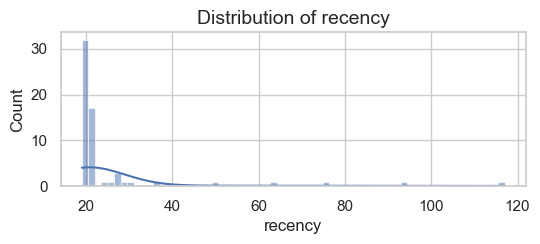

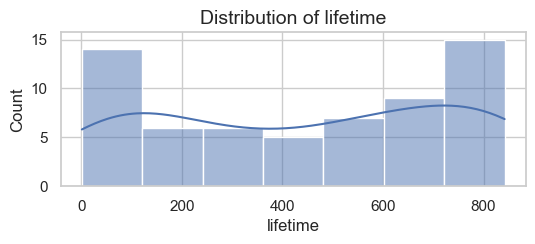

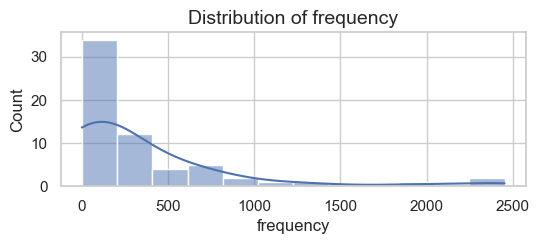

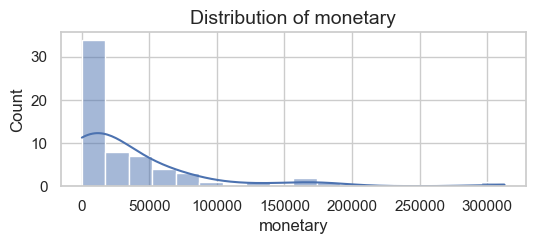

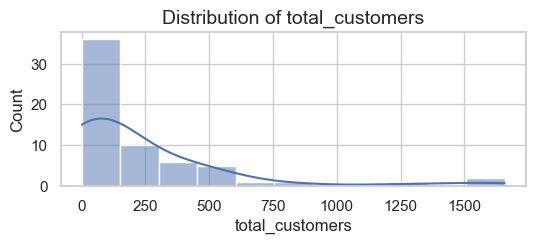

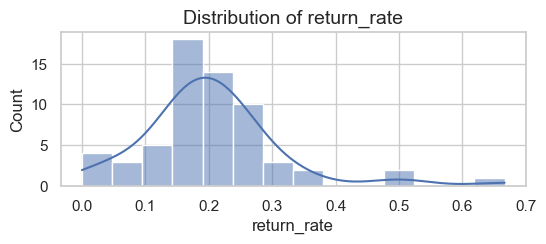

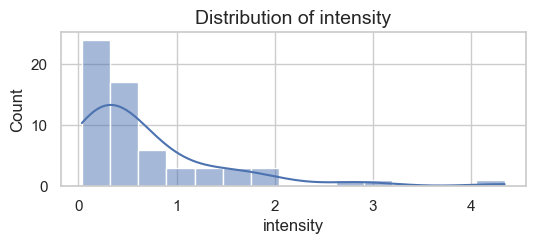

In [31]:
# Create separate plots for each numeric column
for col in rfm_by_full_name.select_dtypes(include='number').columns:
    plt.figure(figsize=(6, 2))
    sns.histplot(data=rfm_by_full_name, x=col, kde=True)
    plt.title(f'Distribution of {col}', fontsize=14)
    plt.show()


In [32]:
rfm_by_full_name.sort_values('return_rate', ascending=False)

,operator,recency,lifetime,frequency,monetary,total_customers,return_rate,intensity
1,Bond Collective-US-DC-Washington,93,9,5,125.00,3,0.666667,0.555556
60,gSpace-US-CT-Fairfield,50,43,3,750.00,2,0.500000,0.069767
59,Workuity-US-AZ-Chandler,22,2,3,950.00,2,0.500000,1.500000
24,Mindspace-IL-Yakum,20,586,80,10959.77,33,0.363636,0.136519
18,Mindspace-GB-London,19,820,1157,125481.03,531,0.333333,1.410976
...,...,...,...,...,...,...,...,...
0,Bond Collective-US-CA-Los Angeles,22,85,21,1362.50,20,0.050000,0.247059
5,Bond Collective-US-PA-Philadelphia,19,80,23,1900.00,22,0.045455,0.287500
35,ROOMS-IL-Modi'in,22,300,27,2434.82,26,0.038462,0.090000
20,Mindspace-IL-Kiryat Ono,22,21,5,402.39,5,0.000000,0.238095


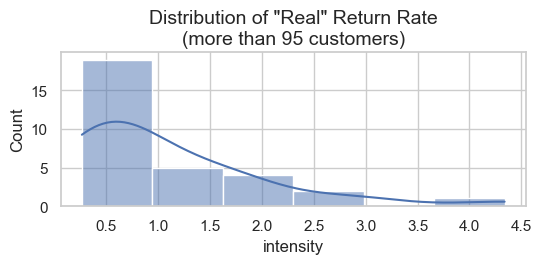

In [33]:
more_than_median =rfm_by_full_name[rfm_by_full_name['total_customers']>rfm_by_full_name['total_customers'].median()].copy()
plt.figure(figsize=(6, 2))
sns.histplot(data=more_than_median, x=col, kde=True)
plt.title(f'Distribution of "Real" Return Rate\n(more than 95 customers)', fontsize=14)
plt.show()



In [35]:
rfm_by_full_name['frequency'].median()

142.0

In [36]:
rfm_by_full_name[rfm_by_full_name['frequency']==2452]

,operator,recency,lifetime,frequency,monetary,total_customers,return_rate,intensity
14,Mindspace-DE-Berlin,19,831,2452,173148.61,1520,0.250658,2.950662


## Segmentation

In [37]:
number_of_days_for_recency = 45
new_operators_days_thresh = 90

In [38]:
rfm_by_full_name.describe()

,recency,lifetime,frequency,monetary,total_customers,return_rate,intensity
count,62.000000,62.000000,62.000000,62.00000,62.000000,62.000000,62.000000
mean,25.983871,446.338710,350.548387,35493.55871,234.564516,0.204469,0.700075
std,17.701988,297.078669,524.059616,55098.78111,344.225032,0.111132,0.797688
min,19.000000,1.000000,1.000000,125.00000,1.000000,0.000000,0.036232
25%,19.000000,140.250000,34.500000,3759.32250,25.250000,0.154600,0.237086
50%,20.000000,488.500000,142.000000,11180.08000,94.500000,0.198697,0.381385
75%,22.000000,706.250000,453.750000,39026.84750,327.750000,0.249282,0.843671
max,117.000000,842.000000,2452.000000,312877.81000,1658.000000,0.666667,4.339552


In [39]:
churned_operators = rfm_by_full_name[rfm_by_full_name['recency']>number_of_days_for_recency].copy()
working_operators = rfm_by_full_name[rfm_by_full_name['recency']<=number_of_days_for_recency].copy()

new_operators = working_operators[working_operators['lifetime']<=new_operators_days_thresh].copy()
experienced_operators= working_operators[working_operators['lifetime']>new_operators_days_thresh].copy()

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


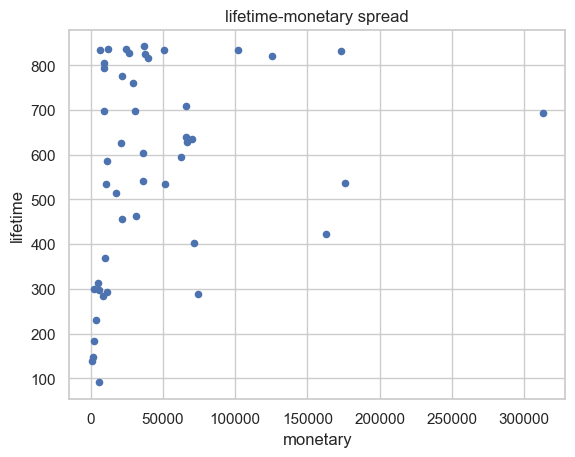

In [82]:
experienced_operators[['lifetime', 'monetary']].plot(kind='scatter', x='monetary', y='lifetime', title = "lifetime-monetary spread");

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


<AxesSubplot:title={'center':'frequency-monetary spread'}, xlabel='frequency', ylabel='monetary'>

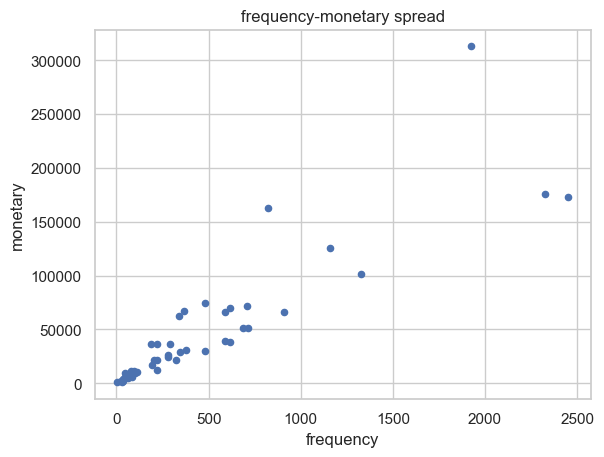

In [41]:
experienced_operators[['monetary', 'frequency']].plot(kind='scatter', x='frequency', y='monetary', title = "frequency-monetary spread")

In [56]:
big_fish = experienced_operators[experienced_operators['monetary']>100000].copy()
not_blooming_yet = experienced_operators[
    (experienced_operators['monetary']<=100000) & 
    (experienced_operators['lifetime']<=400)
].copy()
loyalist = experienced_operators[
    (experienced_operators['monetary']<=100000) & 
    (experienced_operators['lifetime']>400)
].copy()

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


<AxesSubplot:title={'center':'lifetime-monetary spread\nloyalists'}, xlabel='monetary', ylabel='lifetime'>

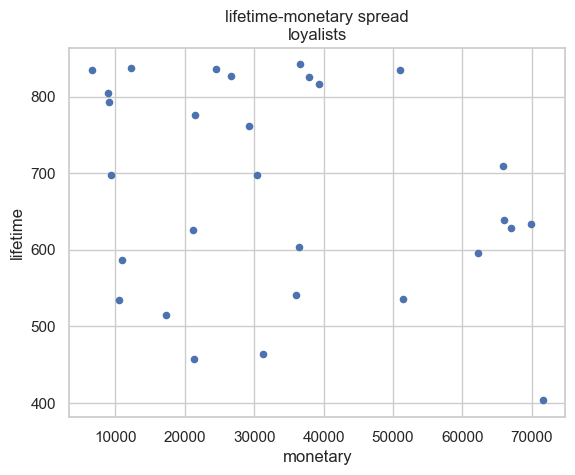

In [67]:
loyalist.sort_values('monetary')
loyalist[['lifetime', 'monetary']].plot(kind='scatter', x='monetary', y='lifetime', title = "lifetime-monetary spread\nloyalists")

In [91]:
churned_operators
working_operators

,operator,recency,lifetime,frequency,monetary,total_customers,return_rate,intensity
0,Bond Collective-US-CA-Los Angeles,22,85,21,1362.50,20,0.050000,0.247059
2,Bond Collective-US-IL-Chicago,19,91,46,5650.00,43,0.069767,0.505495
3,Bond Collective-US-NY-Brooklyn,19,89,173,9650.00,136,0.198529,1.943820
4,Bond Collective-US-NY-New York,20,80,59,4143.75,49,0.142857,0.737500
5,Bond Collective-US-PA-Philadelphia,19,80,23,1900.00,22,0.045455,0.287500
6,Bond Collective-US-TX-Austin,20,87,34,4662.50,31,0.096774,0.390805
7,Brain Embassy-IL-Tel Aviv,19,697,97,9314.35,62,0.225806,0.139168
8,Brain Embassy-PL-Warsaw,19,698,482,30368.67,359,0.200557,0.690544
10,FoundrSpace-US-CA-Pasadena,19,312,62,5235.00,43,0.209302,0.198718
11,FoundrSpace-US-CA-Rancho Cucamonga,26,297,83,5587.50,62,0.145161,0.279461


In [94]:
rfm_oprators = {"churned_operators" : churned_operators,
"new_operators" : new_operators,
"big_fish" : big_fish,
"not_blooming_yet" : not_blooming_yet,
"loyalist" : loyalist,
}


In [95]:
workbook = pd.ExcelWriter("Operators - RFM analysis.xlsx")

for sheet_name, sheet in rfm_oprators.items():
    
    sheet.to_excel(workbook, sheet_name=sheet_name, index=False)
    
workbook.save()

- The most successful operator is the one with the lowest recency, highest frequency and monetary value, highest return rate, longest lifetime


-  'Mindspace' is an extremely successful operator. They have recently transacted (recency of 18 days), have the highest frequency of transactions (9131), and have the highest total transaction value (734809.33). Their return rate (0.256212) is high, and they have a long-standing relationship with us (lifetime of 843 days). Moreover, they have high quartile scores, which means they rank near the top among all operators in recency, frequency, and monetary value. What makes them successful could be their regular and high-frequency transactions, leading to high monetary value. Their high return rate suggests successful transactions, and their long-term engagement implies a stable and strong relationship with us.


- WeWork Israel is a highly successful operator. They frequently transact with us (4256) and bring significant monetary value to our business (661162.90). Their return rate is high (0.269231), suggesting successfull returning customers. They have a longstanding relationship with us (694 days), which underscores their reliability. Given their performance, it's clear that WeWork Israel contributes significantly to our business. Their operations and successful strategies could potentially serve as a benchmark for other operators.


- gSpace is a relatively new operator (66 days) with us, doesn't transact as frequently (7) or with as high values (1850.00) as other operators, but when they do transact, they have a high return rate (0.333333). Their overall performance score is relatively low due to lower frequency and monetary value, but the high return rate suggests potential for future success as they continue to transact with us. This operator could benefit from strategies to increase their transaction frequency and monetary value while maintaining their high return rate.

